# Imports

In [1]:
from model_builder import ModelBuilder
from model_utils import *
import random
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import colorsys
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
plt.rcParams["font.family"] = "Times New Roman"
import warnings
warnings.filterwarnings("ignore")

In [2]:
with open("config.json", "rb") as json_file:
    config = json.load(json_file)
config

{'becker': {'filename': 'beckerestimation_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'mean_pre_discussion_error',
   'mean_post_discussion_error',
   'median_pre_discussion_error',
   'median_post_discussion_error',
   'median_pre_discussion_error_pct',
   'median_post_discussion_error_pct',
   'mean_pre_discussion_error_pct',
   'mean_post_discussion_error_pct',
   'reverse_mean_post_discussion_error_pct',
   'reverse_median_post_discussion_error_pct',
   'question',
   'chatrooms',
   'trial_indx']},
 'csop': {'filename': 'csop_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'batch_num',
   'round_num',
   'round_index',
   'task_index',
   'complexity',
   'type',
   'social_perceptiveness',
   'skill',
   'cogStyleDiversity',
   'skill_diversity',
   'normalized_score',
   'score',
   'duration',
   'efficiency']},
 'csopII': {'filename': 'csopII_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   

# Jury

In [31]:
# Define the basic model
juries_model = ModelBuilder(dataset_names = ["juries"])
juries_model.select_target(target=["majority_pct"])
juries_model.define_model(model_type = 'rf')

# CSOP (blended)

In [32]:
csop_blended_model = ModelBuilder(dataset_names = ["csop", "csopII"])
csop_blended_model.select_target(target=["efficiency", "efficiency"])
csop_blended_model.define_model(model_type = 'rf')

# DAT

In [33]:
dat_model = ModelBuilder(dataset_names = ["dat"])
dat_model.select_target(target=["efficiency"])
dat_model.define_model(model_type = 'rf')

# Estimation

In [34]:
estimation_blended_model = ModelBuilder(dataset_names = ["gurcay", "becker"])
estimation_blended_model.select_target(target=["mean_post_discussion_error_pct", "mean_post_discussion_error_pct"])
estimation_blended_model.define_model(model_type = 'rf')

# Create a PCA plot of the conversation features, colored by task

In [35]:
juries_data = pd.read_csv('../output/jury_output_conversation_level.csv')
csop_data = pd.read_csv('../output/csop_output_conversation_level.csv')
csopII_data = pd.read_csv('../output/csopII_output_conversation_level.csv')
dat_data = pd.read_csv('../output/dat_output_conversation_level.csv')
becker_data = pd.read_csv('../output/beckerestimation_output_conversation_level.csv')
gurcay_data = pd.read_csv('../output/gurcay2015estimation_output_conversation_level.csv')

In [36]:
juries_data, csop_data, csopII_data, dat_data, becker_data, gurcay_data = drop_non_common_columns([juries_data, csop_data, csopII_data, dat_data, becker_data, gurcay_data])

csop_blended_data = pd.concat([csop_data,csopII_data], axis=0)
estimation_blended_data = pd.concat([becker_data,gurcay_data], axis=0)

In [37]:
juries_data, csop_blended_data, dat_data, estimation_blended_data = get_numeric_cols([juries_data, csop_blended_data, dat_data, estimation_blended_data])

In [38]:
juries_data, csop_blended_data, csop_data, csopII_data, dat_data, estimation_blended_data, becker_data, gurcay_data = get_convs_with_min_value([juries_data, csop_blended_data, csop_data, csopII_data, dat_data, estimation_blended_data, becker_data, gurcay_data], "sum_num_messages", 10)

# PCA of Datasets

How do people "speak differently" across different tasks? Can we identify these different patterns of speaking just through clustering each conversation?

In [39]:
labels = ["Mock Jury", "Room Assignment Task", "Divergent Association Task", "Estimation"]
dataset_labels = ["Mock Jury", "CSOP", "CSOPII", "DAT", "Estimation (Becker)", "Estimation (Gurcay)"]

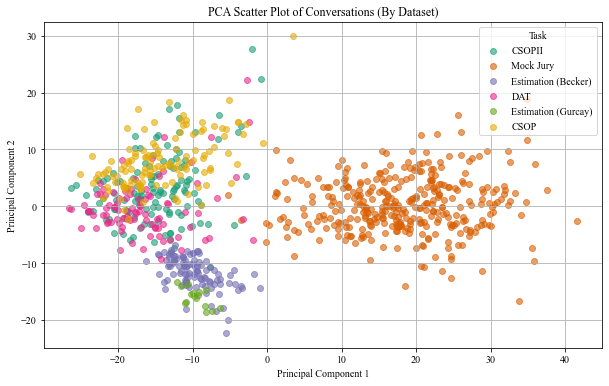

In [40]:
pca_results = plot_pca_of_dataframes(juries_data, csop_data, csopII_data, dat_data, becker_data, gurcay_data, labels=dataset_labels, title = "PCA Scatter Plot of Conversations (By Dataset)")

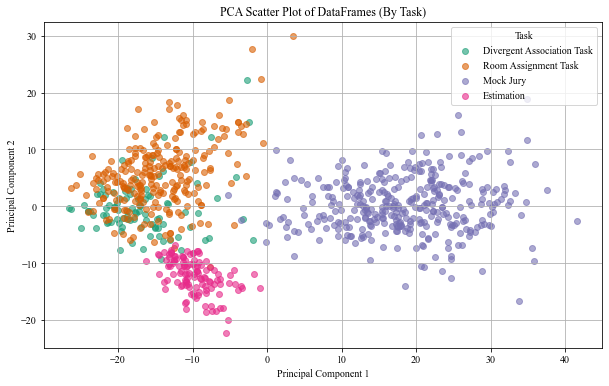

In [41]:
pca_results = plot_pca_of_dataframes(juries_data, csop_blended_data, dat_data, estimation_blended_data, labels=labels, title = "PCA Scatter Plot of DataFrames (By Task)")

In [42]:
pca_results.explained_variance_ratio_

array([0.2831507, 0.0547003])

In [43]:
examine_top_n_components(pca_results, n=10)

Top 5 Features for PC1:
                                     Feature       PC1       PC2   PC1_abs  \
475               average_user_avg_num_chars  0.055270 -0.003036  0.055270   
572  average_user_avg_nltk_english_stopwords  0.055269  0.000405  0.055269   
388               average_user_avg_num_words  0.055257 -0.001247  0.055257   
877           average_nltk_english_stopwords  0.055113  0.001155  0.055113   
686                        average_num_chars  0.055105 -0.002558  0.055105   
768                        average_num_words  0.055071 -0.000526  0.055071   
384               average_user_sum_num_chars  0.054864  0.034962  0.054864   
20   average_user_sum_nltk_english_stopwords  0.054745  0.034887  0.054745   
736          average_user_avg_cognitive_mech  0.054600 -0.001223  0.054600   
250                   average_user_avg_verbs  0.054541  0.000520  0.054541   

      PC2_abs  
475  0.003036  
572  0.000405  
388  0.001247  
877  0.001155  
686  0.002558  
768  0.000526  
384  

,Feature,PC1,PC2,PC1_abs,PC2_abs
0,max_negation,0.041458,-0.017209,0.041458,0.017209
1,stdev_tentativeness,0.040782,-0.018934,0.040782,0.018934
2,average_user_sum_positivity_zscore_chats,-0.008577,0.001382,0.008577,0.001382
3,min_user_avg_auxiliary_verbs,0.047443,0.029826,0.047443,0.029826
4,stdev_first_pronouns_proportion,-0.011698,-0.033459,0.011698,0.033459
...,...,...,...,...,...
1034,min_user_sum_exclusive,0.032474,0.037610,0.032474,0.037610
1035,average_user_sum_humans,0.037571,0.019632,0.037571,0.019632
1036,max_see,-0.000522,0.018767,0.000522,0.018767
1037,average_user_sum_bio,0.018574,0.019115,0.018574,0.019115


PC 1 mostly captures *the quantity of how much people talk*.

PC 2 captures a combination of ideas: Type-Token Ratio, Number of Messages, Subjectivity, Positivity.

In general, Juries talk the most > Estimation second > CSOP / DAT last.

In general, Estimation has a lower PC2 (lower type/token ratio, lower positivity...)

## How much do all the other PC's tell us?
Answer: not a ton...

In [44]:
full_pca = get_pca_of_dataframes([juries_data, csop_blended_data, dat_data, estimation_blended_data], n_components = 10)

([<matplotlib.axis.XTick at 0x14b9e1400>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9')])

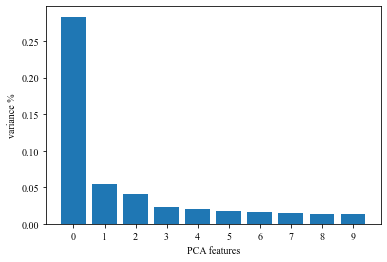

In [45]:
var = full_pca.explained_variance_ratio_
plt.bar(list(range(var.shape[0])),var)
feature = range(full_pca.n_components_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(feature)

# PCA of Features

Can we now model each feature as a point, and see how the different features relate to each other?

(The following code generates an interactive PCA plot, but opens in a brower window.)

Columns with NaN values: ['min_factuality', 'min_quantifier', 'min_money', 'min_user_sum_indirect_(btw)', 'stdev_user_sum_indirect_(btw)', 'min_2nd_person_start', 'max_user_avg_num_messages', 'min_direct_question', 'average_user_sum_indirect_(btw)', 'min_2nd_person', 'min_deference', 'min_user_sum_please', 'min_indirect_(greeting)', 'min_user_avg_NTRI', 'min_hedge_words', 'min_apologizing', 'stdev_num_messages', 'min_subjunctive', 'min_hasnegative', 'min_hedges', 'average_user_avg_indirect_(btw)', 'min_user_avg_factuality', 'stdev_indirect_(btw)', 'min_user_avg_sexual', 'min_indefinite_pronoun', 'max_num_messages', 'average_num_messages', 'min_inclusive', 'min_haspositive', 'min_bio', 'min_positive_words', 'stdev_user_avg_indirect_(btw)', 'max_indirect_(btw)', 'min_first_person_plural', 'min_indirect_(btw)', 'min_user_sum_factuality', 'min_body', 'min_achievement', 'min_anxiety', 'min_user_avg_indicative', 'min_gratitude', 'min_1st_person', 'min_user_sum_sexual', 'min_home', 'max_user_

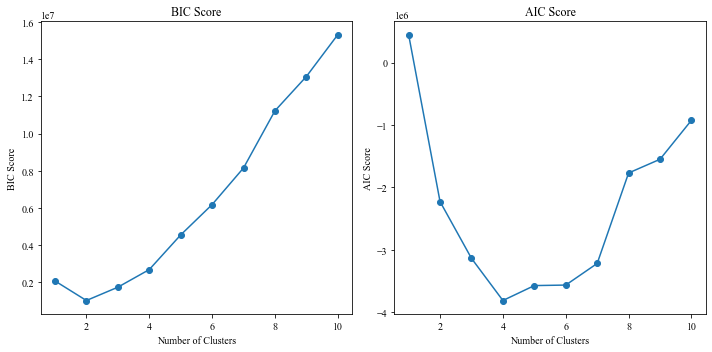

In [46]:
visualize_feature_clusters([juries_data, csop_blended_data, dat_data, estimation_blended_data], use_aic = True, title = "PCA Scatter Plot of Conversational Features")

Columns with NaN values: ['min_factuality', 'min_quantifier', 'min_money', 'min_user_sum_indirect_(btw)', 'stdev_user_sum_indirect_(btw)', 'min_2nd_person_start', 'max_user_avg_num_messages', 'min_direct_question', 'average_user_sum_indirect_(btw)', 'min_2nd_person', 'min_deference', 'min_user_sum_please', 'min_indirect_(greeting)', 'min_user_avg_NTRI', 'min_hedge_words', 'min_apologizing', 'stdev_num_messages', 'min_subjunctive', 'min_hasnegative', 'min_hedges', 'average_user_avg_indirect_(btw)', 'min_user_avg_factuality', 'stdev_indirect_(btw)', 'min_user_avg_sexual', 'min_indefinite_pronoun', 'max_num_messages', 'average_num_messages', 'min_inclusive', 'min_haspositive', 'min_bio', 'min_positive_words', 'stdev_user_avg_indirect_(btw)', 'max_indirect_(btw)', 'min_first_person_plural', 'min_indirect_(btw)', 'min_user_sum_factuality', 'min_body', 'min_achievement', 'min_anxiety', 'min_user_avg_indicative', 'min_gratitude', 'min_1st_person', 'min_user_sum_sexual', 'min_home', 'max_user_

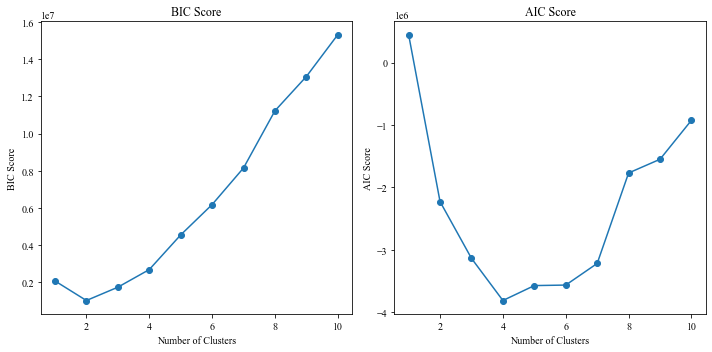

In [47]:
# Get more insight into the clusters!
all_data = pd.concat([juries_data, csop_blended_data, dat_data, estimation_blended_data], join = 'inner', ignore_index = True)

'''
The below reproduces the code from inside the plotting function, but gives us access to the actual cluster labels to 
play around with!
'''

# Normalize (Across all tasks)
columns_to_normalize = [col for col in all_data.columns if col != 'task_name']
normalized_df = all_data.copy()
normalized_df[columns_to_normalize] = normalized_df[columns_to_normalize].transform(lambda x: (x - x.mean()) / x.std())

# Drop NA columns
nan_cols, nan_rows = check_na_rows_cols(normalized_df)
normalized_df = normalized_df.drop(nan_cols, axis = 1)

normalized_data_transposed = normalized_df.drop(["task_name"], axis=1).T

# Get Clusters (using GMM) for the data, on the full-dimensional dataset.
cluster_labels = get_gaussian_mixture_clustering(normalized_data_transposed, use_aic=True)

In [48]:
normalized_data_transposed["cluster"] = cluster_labels

In [49]:
def explore_clustered_features(df, num_closest=5):
    unique_clusters = df['cluster'].unique()
    nearest_points_df = pd.DataFrame()

    for cluster_label in unique_clusters:
        cluster_data = df[df['cluster'] == cluster_label]
        features = cluster_data.drop(columns=['cluster'])

        centroid = features.mean(axis=0)
        similarity_scores = cosine_similarity([centroid], features).flatten()

        # Get the num_closest data points with highest similarity
        nearest_indices = np.argsort(similarity_scores)[-num_closest:]
        nearest_cluster_points = cluster_data.iloc[nearest_indices]
        nearest_points_df = pd.concat([nearest_points_df, nearest_cluster_points])

    return nearest_points_df

Explore the top n (=10) features per cluster, by examining the closest features to the cluster centroid. What is "most representative" of the cluster?

TODO: these clusters are not super interpretable...

In [50]:
top_10_features_per_cluster = explore_clustered_features(normalized_data_transposed, num_closest = 10)
pca = PCA(n_components=2)
pca_top = pca.fit_transform(top_10_features_per_cluster.drop(["cluster"], axis = 1))

# Create a new DataFrame with the PC scores and row names
pca_df = pd.DataFrame(data=pca_top, columns=["PC1", "PC2"], index=top_10_features_per_cluster.index)
pca_df["cluster"] = top_10_features_per_cluster["cluster"]

generate_interactive_feature_plot(pca_df, "PCA of Top 5 Features Per Cluster")

## PCA of User Features

In [23]:
jury_users = pd.read_csv('../output/jury_output_user_level.csv')
csop_users = pd.read_csv('../output/csop_output_user_level.csv')
csopII_users = pd.read_csv('../output/csopII_output_user_level.csv')
dat_users = pd.read_csv('../output/dat_output_user_level.csv')
becker_estimation_users = pd.read_csv('../output/beckerestimation_output_user_level.csv')
gurcay_estimation_users = pd.read_csv('../output/gurcay2015estimation_output_user_level.csv')

In [24]:
# Get Non-Empty Conversations
jury_users, csop_users, csopII_users, dat_users, becker_estimation_users, gurcay_estimation_users = get_users_in_nonempty_conversations([jury_users, csop_users, csopII_users, dat_users, becker_estimation_users, gurcay_estimation_users])

In [25]:
# Preprocess the user dataframes
jury_users, csop_users, csopII_users, dat_users, becker_estimation_users, gurcay_estimation_users = drop_non_common_columns([jury_users, csop_users, csopII_users, dat_users, becker_estimation_users, gurcay_estimation_users])

csop_blended_users = pd.concat([csop_users,csopII_users], axis=0)
estimation_blended_users = pd.concat([becker_estimation_users,gurcay_estimation_users], axis=0)

# Then get only the numeric columns
jury_users, csop_blended_users, dat_users, estimation_blended_users = get_numeric_cols([jury_users, csop_blended_users, dat_users, estimation_blended_users])

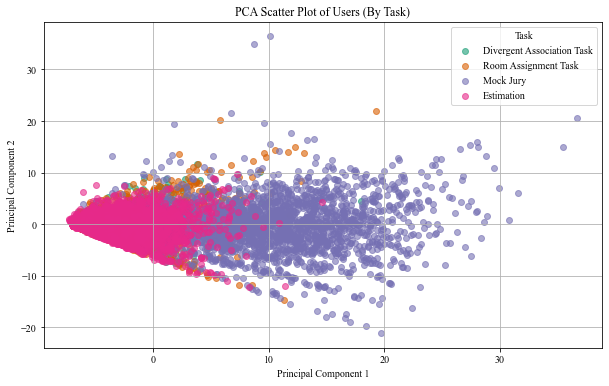

In [26]:
pca_results_users = plot_pca_of_dataframes(jury_users, csop_blended_users, dat_users, estimation_blended_users, labels=labels, title = "PCA Scatter Plot of Users (By Task)")

In [27]:
pca_results_users.explained_variance_ratio_

array([0.26327829, 0.05470521])

In [28]:
examine_top_n_components(pca_results_users, n=10)

Top 5 Features for PC1:
                        Feature       PC1       PC2   PC1_abs   PC2_abs
169  sum_nltk_english_stopwords  0.136225  0.061513  0.136225  0.061513
178               sum_num_chars  0.136074  0.070750  0.136074  0.070750
56                sum_num_words  0.135995  0.077420  0.135995  0.077420
33           sum_cognitive_mech  0.134440  0.057344  0.134440  0.057344
175                   sum_verbs  0.133991  0.060913  0.133991  0.060913
110         sum_auxiliary_verbs  0.131312  0.058548  0.131312  0.058548
8                    sum_social  0.127877  0.046319  0.127877  0.046319
9             sum_present_tense  0.127853  0.069428  0.127853  0.069428
52              sum_preposition  0.126775  0.046809  0.126775  0.046809
6             average_num_words  0.124728 -0.133995  0.124728  0.133995

Top 5 Features for PC2:
                                Feature       PC1       PC2   PC1_abs  \
167                        sum_word_TTR  0.071218  0.233086  0.071218   
103          

,Feature,PC1,PC2,PC1_abs,PC2_abs
0,sum_family,0.096868,0.011722,0.096868,0.011722
1,sum_positivity_zscore_chats,-0.020300,0.084095,0.020300,0.084095
2,sum_function_word_accommodation,0.119640,0.019552,0.119640,0.019552
3,average_indirect_(greeting),-0.013440,0.006656,0.013440,0.006656
4,average_humans,0.049596,-0.046251,0.049596,0.046251
...,...,...,...,...,...
182,average_auxiliary_verbs,0.114350,-0.118986,0.114350,0.118986
183,sum_hear,0.080441,0.036097,0.080441,0.036097
184,average_hear,0.055625,-0.048239,0.055625,0.048239
185,sum_2nd_person_start,0.014234,0.050759,0.014234,0.050759
